<a href="https://colab.research.google.com/github/prachi-agrawal1179/DAE-Cifar-10/blob/master/DAE_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
   Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10

In [ ]:
(train_data_clean, _), (test_data_clean, _) = cifar10.load_data()

In [ ]:
train_data_clean = train_data_clean.astype('float32') / 255.
test_data_clean = test_data_clean.astype('float32') / 255.

In [ ]:
def addnoisedata(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

A = addnoisedata(train_data_clean)
B = addnoisedata(test_data_clean)

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
def deconv_block(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
def denoising_autoencoder():
   dae_inputs = Input(shape=(32, 32, 3), name='dae_input')
   conv_block1 = conv_block(dae_inputs, 32, 3)
   conv_block2 = conv_block(conv_block1, 64, 3)
   conv_block3 = conv_block(conv_block2, 128, 3)
   conv_block4 = conv_block(conv_block3, 256, 3)
   conv_block5 = conv_block(conv_block4, 256, 3, 1)
   deconv_block1 = deconv_block(conv_block5, 256, 3)
   merge1 = Concatenate()([deconv_block1, conv_block3])
   deconv_block2 = deconv_block(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = deconv_block(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = deconv_block(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3,kernel_size=3,padding='same')(deconv_block4)
   dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   return Model(dae_inputs, dae_outputs, name='dae')

In [ ]:
dae = denoising_autoencoder()
dae.compile(loss='mse', optimizer='adam')
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=True)
dae.fit(A,train_data_clean,validation_data=(B, test_data_clean),epochs=3,batch_size=128,callbacks=[checkpoint])

Epoch 1/3
391/391 [==============================] - ETA: 0s - loss: 0.0048
Epoch 00001: val_loss improved from inf to 0.00456, saving model to best_model.h5
391/391 [==============================] - 485s 1s/step - loss: 0.0048 - val_loss: 0.0046
Epoch 2/3
391/391 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00002: val_loss improved from 0.00456 to 0.00246, saving model to best_model.h5
391/391 [==============================] - 486s 1s/step - loss: 0.0024 - val_loss: 0.0025
Epoch 3/3
391/391 [==============================] - ETA: 0s - loss: 0.0022
Epoch 00003: val_loss improved from 0.00246 to 0.00208, saving model to best_model.h5
391/391 [==============================] - 486s 1s/step - loss: 0.0022 - val_loss: 0.0021


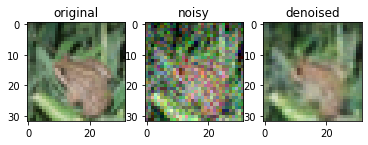

In [ ]:
dae.load_weights('best_model.h5')
test_data_denoised = dae.predict(B)
idx = 4
plt.subplot(1,3,1)
plt.imshow(test_data_clean[idx])
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(B[idx])
plt.title('noisy')
plt.subplot(1,3,3)
plt.imshow(test_data_denoised[idx])
plt.title('denoised')
plt.show()

In [ ]:
def mse(data_1, data_2):
   return np.square(np.subtract(data_1, data_2)).mean()
noisy_clean_mse = mse(test_data_clean, B)
denoised_clean_mse = mse(test_data_denoised, test_data_clean)
noisy_clean_mse, denoised_clean_mse

(0.009304262920320086, 0.0020778365)